<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Overview-and-Instructions" data-toc-modified-id="Overview-and-Instructions-1">Overview and Instructions</a></span></li><li><span><a href="#The-data" data-toc-modified-id="The-data-2">The data</a></span></li><li><span><a href="#Model-Comparison" data-toc-modified-id="Model-Comparison-3">Model Comparison</a></span></li></ul></div>

In [1]:
set.seed(123)


### Overview and Instructions

The goal of this lab is to walk you through a simple analysis of the data on airline passenger data using our simple time series extensions to regression.

Below you will add code to generate data, plots, etc., into the appropriate portions of the RMarkdown document. Be sure the answer all of the ___questions___.


### The data

The data you will explore consist of data on monthly numbers of international airline passengers from 1949 to 1961. These data can be found in the ${\tt airline.csv}$ data file on GitHub.



In [3]:
airline <- read.csv("../../data/airline.csv")



First we plot the data. Notice I plot this a bit differently than
usual.



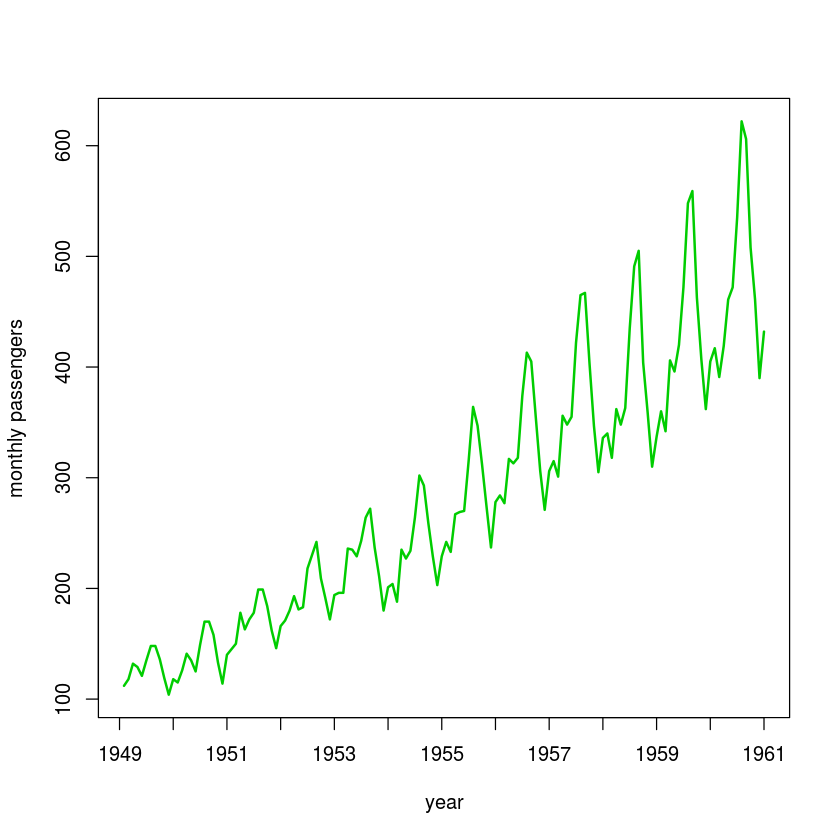

In [4]:
plot(airline$Passengers, xlab="year", ylab="monthly passengers",
     type="l", col=3, lwd=2, xaxt="n")
axis(1, at=(0:12)*12, labels=1949:1961)


___Q1: What does xaxt="n" mean? What does the axis function do?___

The first tells the plot function not to include the x axis. Then the axis function is used to put in the axis manually.

<br>
<Br>


Next, use the acf function to plot the auto-correlation function of the Passesngers data.


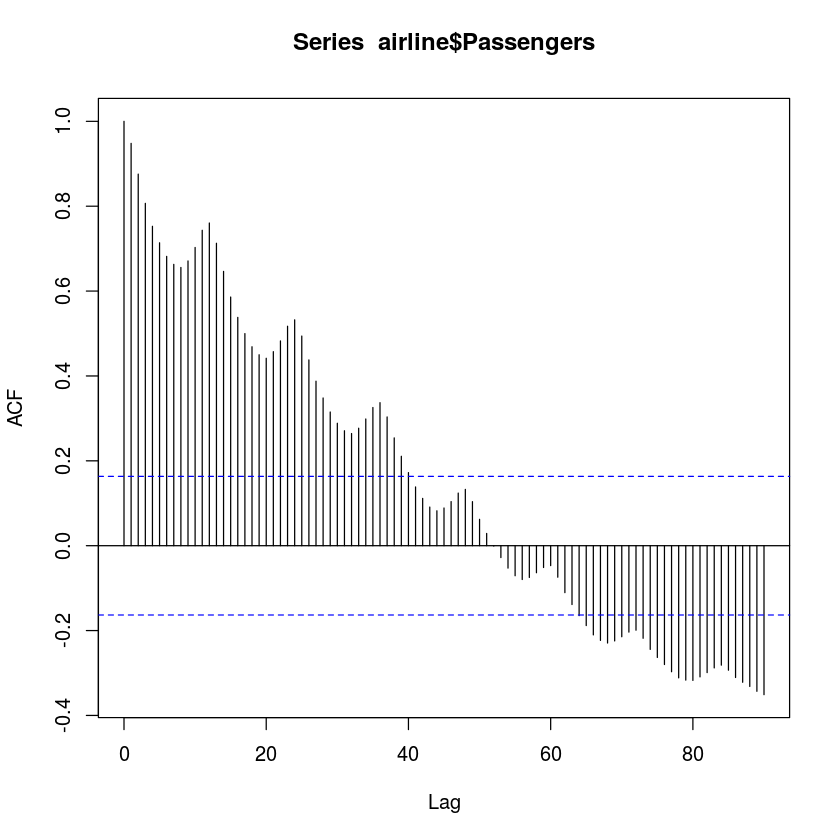

In [5]:
acf(airline$Passengers, lag.max=90)


___Q2: From the two plots above, what things do you notice about the data? What transforms might you need to take of the data? What kinds of covariates might you need to add in?___

The data seems to have both a linear trend (up) and a periodic pattern. Further the variance seems to increase over time (trumpet). The ACF plot also indicates that there is autocorrelation in the data, and you can also see a bit of the periodic pattern. We'll need to include an AR predictor, a time variable (for the trend) and sine/cosine predictors for the period covaariates. Also, we'll want to take a log to take care of the trumpetting variance.

<br>
<br>


Re-plot the from data above using a log transform of the response (passenger).



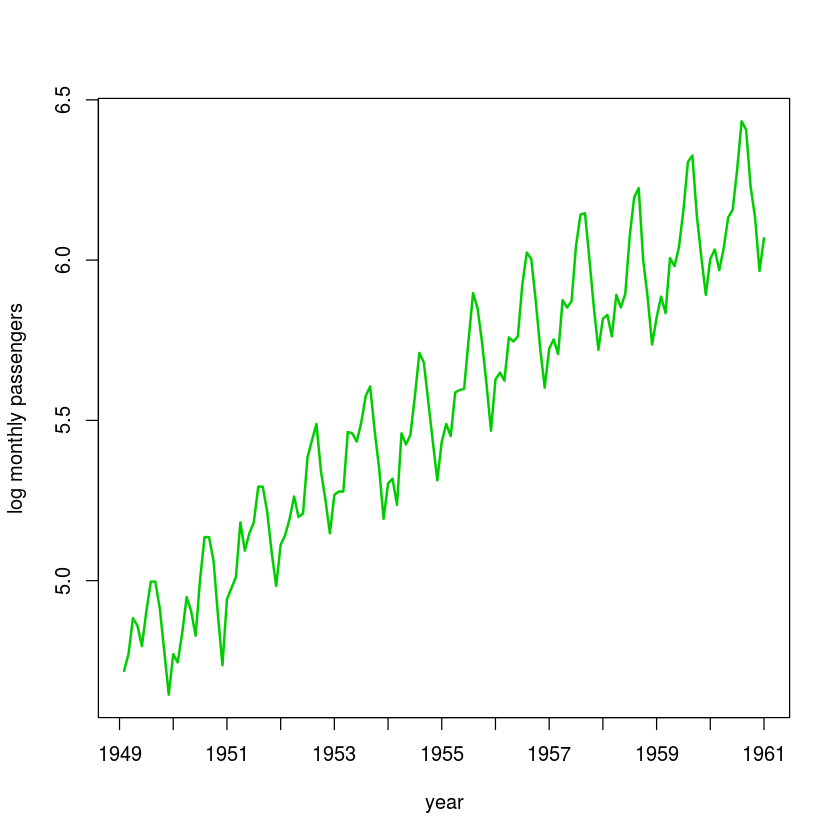

In [6]:
plot(log(airline$Passengers), xlab="year",
     ylab="log monthly passengers",
     type="l", col=3, lwd=2, xaxt="n")
axis(1, at=(0:12)*12, labels=1949:1961)



Now it's time to build a data frame to hold the data.

First we make a time covariate


In [7]:
t <- 2:nrow(airline)


Now, into the data frame, we'll add the following covariates:

1. logY: log of the number of passengers (I've started this for you)
2. logYpast: this is your auto-regressive term, the log of the passengers from the previous month
3. t: month number
4. sin12: sine terms with period of 12 months
5. cos12: cosine term with period of 12 months



In [8]:
YX <- data.frame(logY=log(airline$Passengers[2:144]),
                 logYpast=log(airline$Passengers[1:143]), t=t,
                 sin12=sin(2*pi*t/12), cos12=cos(2*pi*t/12))


Fit a linear model with logY as the response and the other 4 components as predictors. Look at the summary of the fit.



In [9]:
airlm <- lm(logY ~ logYpast + t + sin12 + cos12, data=YX)
summary(airlm)


Call:
lm(formula = logY ~ logYpast + t + sin12 + cos12, data = YX)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.208137 -0.063849  0.002261  0.065483  0.152088 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.5323909  0.3603010   7.029 8.77e-11 ***
logYpast     0.4748286  0.0749506   6.335 3.12e-09 ***
t            0.0052759  0.0007703   6.849 2.25e-10 ***
sin12        0.0040818  0.0126512   0.323    0.747    
cos12       -0.0960295  0.0119032  -8.068 3.12e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.07929 on 138 degrees of freedom
Multiple R-squared:  0.9681,	Adjusted R-squared:  0.9672 
F-statistic:  1047 on 4 and 138 DF,  p-value: < 2.2e-16



___Q3: Are all of the predictors significant? What is the $R^2$ of your regression?___

No, the sin12 isn't significant (although we usually will leave both in). the $R^2$ is 0.9681 -- we seem to be able to explain almost 97% of the variance!


Next, we plot the data on a log scale (drawn with a dotted line).  Overlay the FITTED values from your regression (e.g., if your regression model was called "reg" you want to plot reg$fitted vs t) as a solid line in another color. This solid line is your prediction.


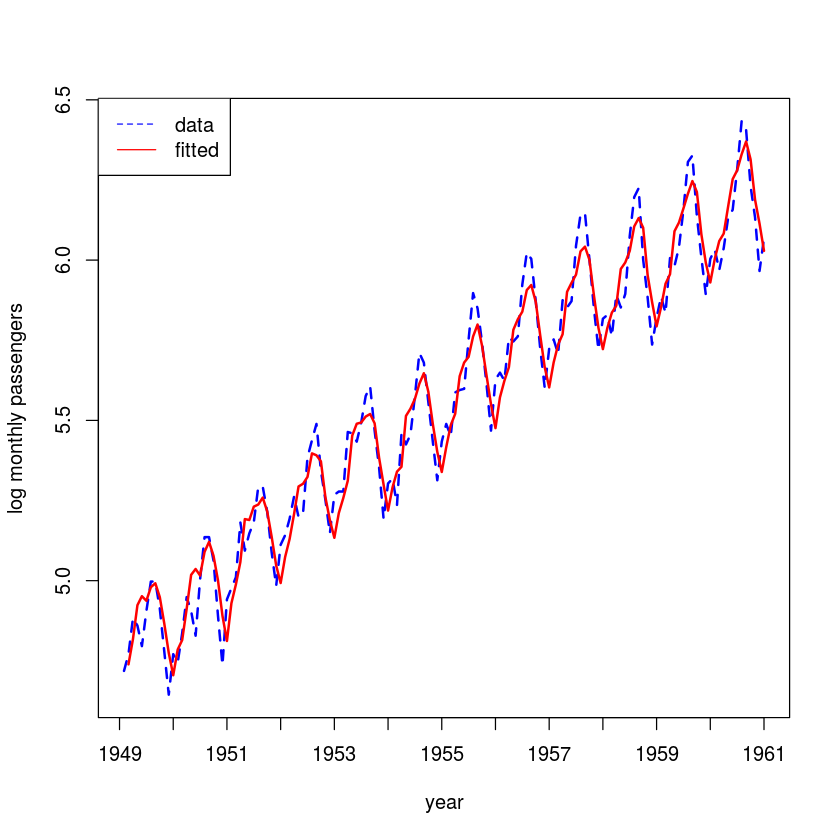

In [10]:
plot(log(airline$Passengers), xlab="year",
     ylab="log monthly passengers", type="l", col=4, lty=2,
     xaxt="n", lwd=2)
axis(1, at=(0:12)*12, labels=1949:1961)
lines(t, airlm$fitted, col=2, lwd=2)
legend("topleft", legend=c("data", "fitted"), lty=c(2,1), col=c(4,2))


The difference between the solid and dotted lines at each month are your residuals across time. As always, we want to also look at our residuals explicitly to see if we're doing a good job of explaining things. For TS we primarily look at residuals across time, and the ACF of our residuals. So make those two plots here.



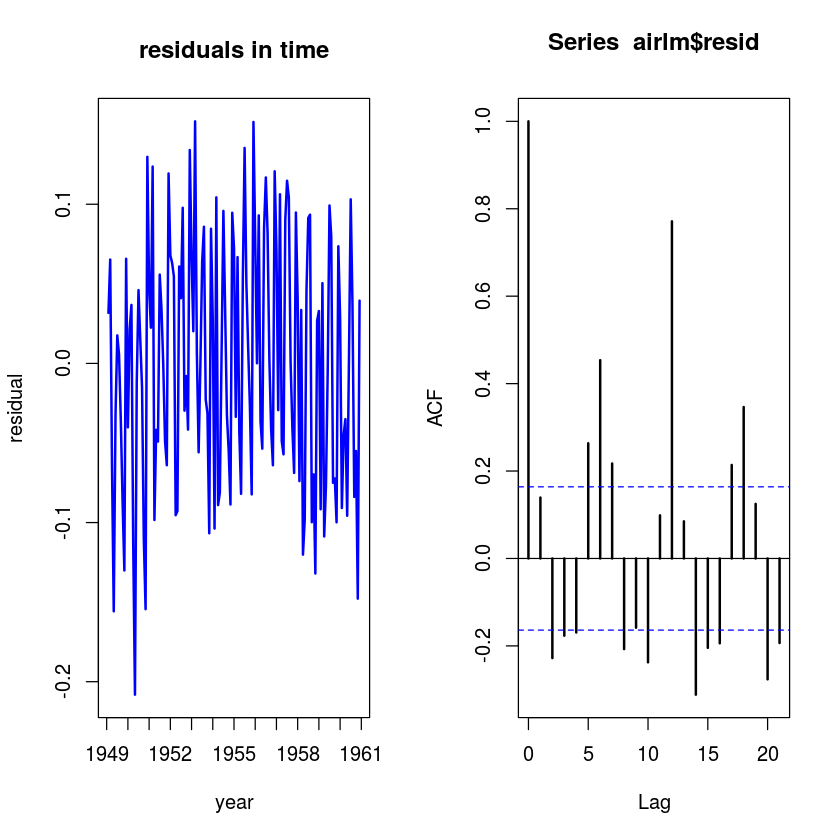

In [11]:
par(mfrow=c(1,2))
plot(airlm$resid, xlab="year", ylab="residual", type="l",
     col=4, main="residuals in time",  xaxt="n", lwd=2)
axis(1, at=(0:12)*12, labels=1949:1961)
acf(airlm$resid, lwd=2)



__Q: How do these look? What do you notice about the residuals, esp the ACF?___

The residuals against time loos like there might still be a pattern, and the ACF plot indicates that we've got some leftover autocorrelation that we have explained well yet that we shoudl take care of.

<br>
<br>


It turns out that there is a month effect that we're missing. Here
is one way to look at it (note we have to index by t so that everything lines up properly):



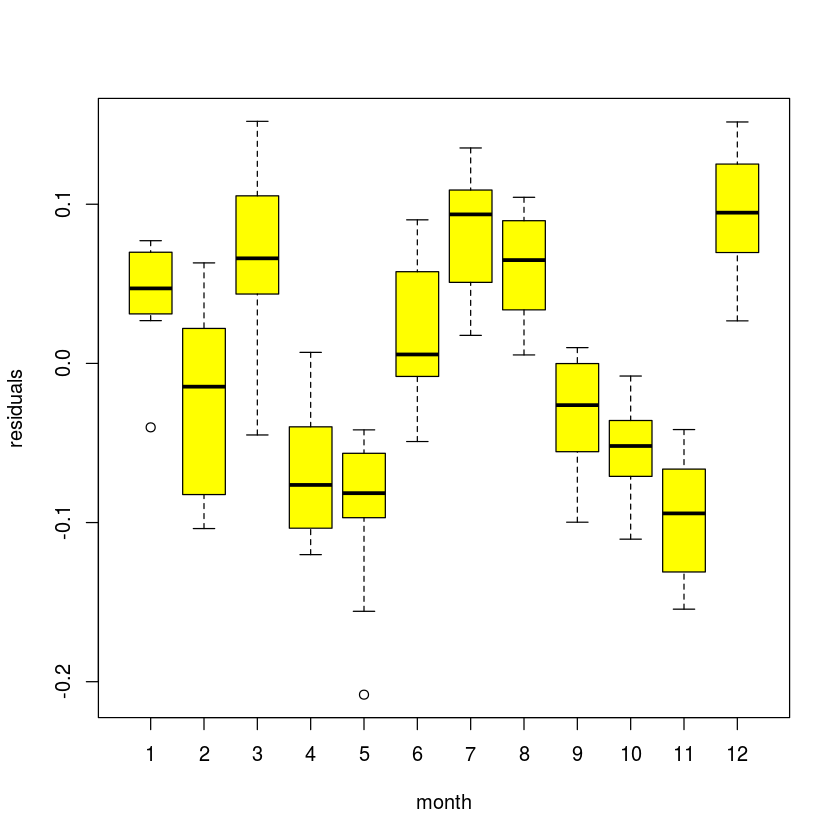

In [12]:
boxplot(airlm$resid ~ airline$Month[t], xlab="month",
        ylab="residuals", col=7)


Residuals in months with lots of school holidays (March, summer,
December) are consistantly high. Let's create a dummy variable
called "holidays" that tells whether a particular passenger record
is for a month that has lots of holidays.


In [13]:
YX$holidays <- airline$Month[t] %in% c(3,6,7,8,12)


Fit a new lm that adds this holiday variable on to what you had before, and then re-examine the residuals, including by month.


In [14]:
airlm2 <- lm(logY ~ logYpast + t + sin12 + cos12 + holidays, data=YX)
summary(airlm2)


Call:
lm(formula = logY ~ logYpast + t + sin12 + cos12 + holidays, 
    data = YX)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.115641 -0.035515 -0.000503  0.034300  0.089932 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.0230597  0.2252847   4.541 1.21e-05 ***
logYpast      0.7763351  0.0465736  16.669  < 2e-16 ***
t             0.0022282  0.0004775   4.666 7.22e-06 ***
sin12         0.0470794  0.0076927   6.120 9.25e-09 ***
cos12        -0.0330684  0.0077860  -4.247 3.97e-05 ***
holidaysTRUE  0.1488552  0.0088545  16.811  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.04547 on 137 degrees of freedom
Multiple R-squared:  0.9896,	Adjusted R-squared:  0.9892 
F-statistic:  2603 on 5 and 137 DF,  p-value: < 2.2e-16


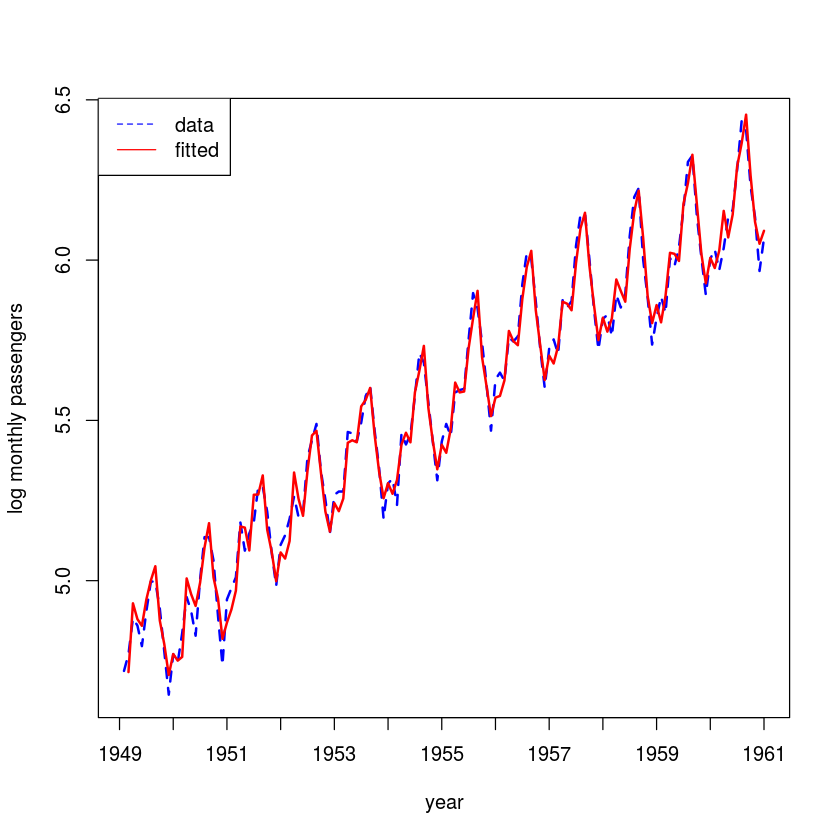

In [15]:
plot(log(airline$Passengers), xlab="year", ylab="log monthly passengers",
     type="l", col=4, lty=2, xaxt="n", lwd=2)
axis(1, at=(0:12)*12, labels=1949:1961)
lines(t, airlm2$fitted, col=2, lwd=2)
legend("topleft", legend=c("data", "fitted"), lty=c(2,1), col=c(4,2))

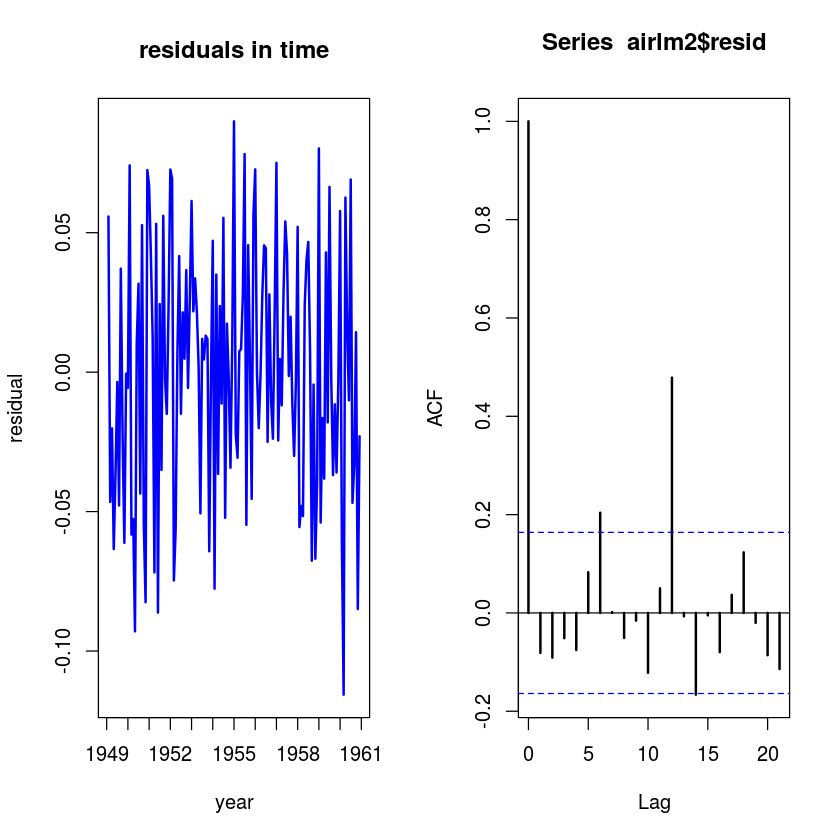

In [16]:
par(mfrow=c(1,2))
plot(airlm2$resid, xlab="year", ylab="residual", type="l", col=4,
     main="residuals in time",  xaxt="n", lwd=2)
axis(1, at=(0:12)*12, labels=1949:1961)
acf(airlm2$resid, lwd=2)

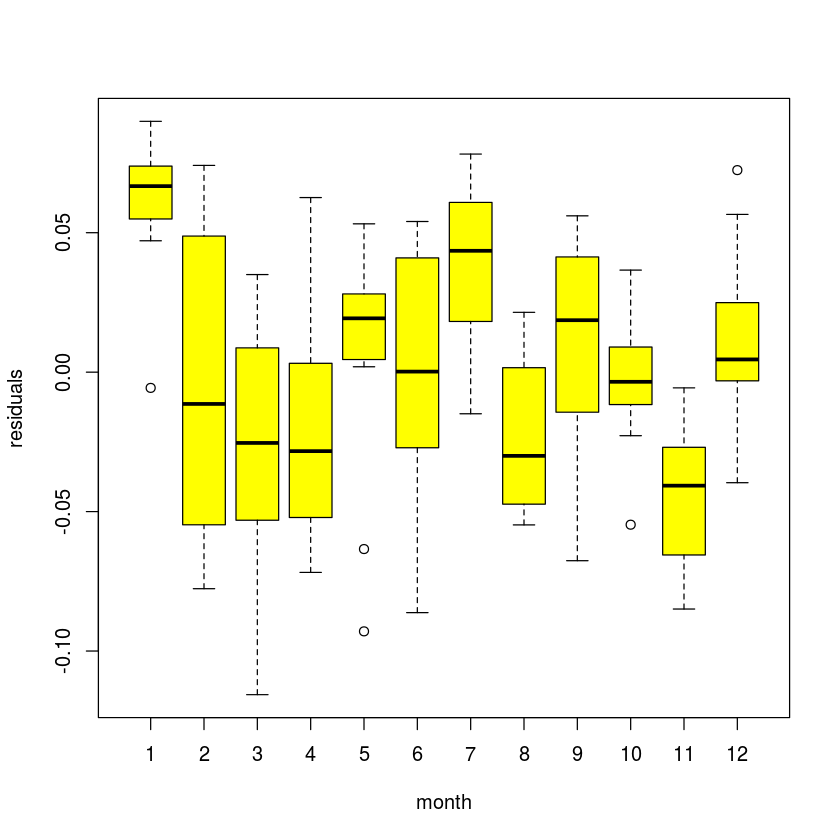

In [17]:
par(mfrow=c(1,1))
boxplot(airlm2$resid ~ airline$Month[t], xlab="month",
        ylab="residuals", col=7)



### Model Comparison

Now you have 2 nested models. Because they are nested, we can compare them in two ways. First I do a partial F-test. The idea behind the F-test is that it looks at the difference in the $R^2$ value between the two models and determines whether or not this difference is large enough to warrent the additional covariates. If we use the "anova" function in R and provide both fittend model objects as arguments, it will automatically perform a partial F-test.



In [ ]:
anova(airlm2, airlm)


___Q: Based on these what model would you choose and why?___

This test indicates that the more complex model is significantly better than the simple model.

<br>

We can also compare the models via BIC (the Bayesian Information Criterion) and the approximate relative model probabilities based on the BICs. Note that we can use BIC/model probabilities to compare between models even if the models are not nested, as long as the response being modeled is the same in each case.


In [18]:
n<-length(YX$logY)-1
bics<-c(airlm=extractAIC(airlm, k=log(n))[2],
        airlm2=extractAIC(airlm2, k=log(n))[2])

ebics<-exp(-0.5*(bics-min(bics)))

probs<-ebics/sum(ebics)

rbind(round(bics, 5), round(probs, 5))


airlm,airlm2
-705.2312,-860.3454
0.0000,1.0000



___Q: Which model is the best via BIC? Does this jive with what the partial F-test told you? What is the $R^2$ for your best model. Based on this model selection, $R^2$ and what you saw in the residuals for this model, do you feel satisfied that your model is capturing the patterns in the data? Would you want to go back and fit anything else?___


The best of these is also definitely airlm2 with all of the extra bits. This agrees with what I saw using the F-test. The $R^2$ for this model is a remarkable 0.9896 -- we're fitting really well. However, there are still some months that are a lot different from the others, so I suspect that, although this is a good model, we could probably do better by adding in more dummy variables.

<br>
<br>


